## Wind Power in a Cold Climate

Wind power plays an important role in world's renewable energy production. In this Notebook we wanted to show the relation between temperature, wind speed and energy consumption. For example location we have chosen Estonia. Lying in the northern part of a temperate zone, between maritime and continental climate, Estonia is well situated to harness wind power. This is not lost of the various companies servicing the Estonian market; since August 2017, Estonian wind production has gone up 36% from the previous year.

In this example we are using __[ECMWF ERA5 dataset](https://data.planetos.com/datasets/ecmwf_era5)__ dataset from __[Planet OS Datahub](https://data.planetos.com)__.


API documentation is available at http://docs.planetos.com. If you have questions or comments, join the Planet OS Slack community to chat with our development team. For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/. This Notebook runs with Python3. 

In [80]:
import os
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
from matplotlib.dates import MonthLocator, DayLocator, YearLocator
import matplotlib.pyplot as plt
import numpy as np
import wget
from netCDF4 import num2date
import pandas as pd
import matplotlib as mpl
import shutil
mpl.rcParams['font.family'] = 'Avenir Lt Std'
mpl.rcParams.update({'font.size': 25})

print ('numpy version ' + np.__version__)
print ('matplotlib version ' + mpl.__version__)

numpy version 1.15.4
matplotlib version 3.0.2


<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [81]:
server='api.planetos.com/'
version = 'v1'
API_key = open('APIKEY').read().strip()
dh=datahub.datahub(server,version,API_key)

Here we define dataset __[ECMWF ERA5 dataset](https://data.planetos.com/datasets/ecmwf_era5)__ namespace, variable names and period start and end. ERA5 has a longer history, but at that point, we have electricity consumption data starting from 2010 and this is the reason we chose period started from 2010. But we encourage you to try it with other data as well.

In [82]:
dataset='ecmwf_era5'
variable_names = '10_metre_V_wind_component_surface,10_metre_U_wind_component_surface,2_metre_temperature_surface'
time_start = '2010-01-01T00:00:00'
time_end = '2017-12-31T12:00:00'

In the following two cells we are downloading the data. The reason we choose two locations is that wind farms are usually built into more windy places, like Hiiumaa island is. But the most people, electricity consumers, live in mainland. Temperatures and wind speed varies a lot in those two regions. 

In [111]:
longitude = 22.6; latitude =  58.89
area_name = 'Hiiu'
package = package_api.package_api(dh,dataset,variable_names,longitude,longitude,latitude,latitude,time_start,time_end,area_name=area_name)
package.make_package()
package.download_package()

In [84]:
longitude = 25.49; latitude = 58.8
area_name = 'estonia_inland'
package2 = package_api.package_api(dh,dataset,variable_names,longitude,longitude,latitude,latitude,time_start,time_end,area_name=area_name)
package2.make_package()
package2.download_package()

Here we define a function that reads in the data and calculates wind speed and direction from components. Many datasets share wind data as components, just like ERA5. 

In [85]:
def get_wind_data(filename):
    dd1 = xr.open_dataset(filename)
    dd1['temp_celsius'] = dd1['2_metre_temperature_surface']  - 272.15
    dd1['temp_fahrenheit'] = dd1.temp_celsius * 1.8000 + 32.00

    ws = np.sqrt((dd1['10_metre_U_wind_component_surface'] * dd1['10_metre_U_wind_component_surface']) + (dd1['10_metre_V_wind_component_surface'] * dd1['10_metre_V_wind_component_surface']))
    wd = 270 - (180 / np.pi) * np.arctan2(np.radians(dd1['10_metre_V_wind_component_surface']), np.radians(dd1['10_metre_U_wind_component_surface']))

    for i in range(0, len(wd)):
        if wd[i] > 360:
            wd[i] = wd[i] - 360

    dd1['wind_speed'] = dd1['10_metre_V_wind_component_surface']
    dd1['wind_speed'].values = ws
    dd1['wind_direction'] = dd1['10_metre_V_wind_component_surface']
    dd1['wind_direction'].values = wd

    return dd1

This is a function for making figures. It's easier to make it once as it can get pretty long if you like your figures to loook good as well (eg. grey borders and grid). It has some parameters to get _threshold_ line on 5 m/s wind speed or _daily_ to make date formatting a little different than it is with yearly data. Also, you are able to save those images to you local system when choosing _savefig_ True.

In [178]:
def make_fig(data1,time1,data2,time2,title,figname,y_label1,y_label2,threshold = False,daily = False,savefig = False):
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(111)
    
    plt.grid(color='#C3C8CE',alpha=1)
    
    ax2 = ax1.twinx()
    
    ax2.plot(time2, data2,'*-',c='#EC5840')
    ax2.set_ylabel(y_label2, color='#EC5840')
    
    ax1.plot(time1, data1, '*-', c='#1B9AA0')
    ax1.set_ylabel(y_label1, color='#1B9AA0')
    
    if threshold == True:
        ax2.plot([min(data2.time0).values - np.timedelta64(1,'D'),max(data2.time0).values + np.timedelta64(1,'D')], [5,5], '-',linewidth = 0.5, c='#EC5840',alpha = 0.8)
        ax2.set_xlim(min(data2.time0).values - np.timedelta64(1,'D'),max(data2.time0).values + np.timedelta64(1,'D'))
        
    
    plt.xticks(rotation=0)
    ax1.set_zorder(ax2.get_zorder() + 1)  # put ax1 in front of ax2
    ax1.patch.set_visible(False)  # hide the 'canvas'
    
    if daily == False:
        ax1.xaxis.set_major_locator(YearLocator())
        ax1.xaxis.set_minor_locator(MonthLocator())
    else:
        ax1.xaxis.set_major_locator(DayLocator(interval=10))
        ax1.xaxis.set_minor_locator(DayLocator(interval=1))
        ax1.set_ylim(-28,10)
        ax2.set_ylim(1,9.4)
    
    ax1.spines['bottom'].set_color('#C3C8CE')
    ax1.spines['top'].set_color('#C3C8CE')
    ax1.spines['left'].set_color('#C3C8CE')
    ax1.spines['right'].set_color('#C3C8CE')
    
    ttl = plt.title(title,fontsize=30,fontweight = 'bold')
    ttl.set_position([.5, 1.05])
    plt.show()
    if savefig == True:
        plt.savefig(figname)
    plt.close()

All the functions we want to use are defined now. It's time to read in the data using get_wind_data function. We read in both datasets with __get_wind_data__ as it's a good addition to have wind_speed for both locations and it's not very time consuming. 

In [112]:
dd1_wnd = get_wind_data(package.local_file_name)
dd2_tmp = get_wind_data(package2.local_file_name)

When data is read in, we want to get monthly mean values as it's a bit unrealistic to plot all data as once. Monthly data is smooth and shows trend. 

In [106]:
monthly_mean_wind = dd1_wnd.wind_speed.resample(time0="1M").mean('time0').mean(dim=('lat', 'lon'))
monthly_mean_temp = dd2_tmp.temp_celsius.resample(time0="1M").mean('time0').mean(dim=('lat', 'lon'))

Let's see yearly relation between temperature and electricity consumption. For that we use elering data and download files per year, as the load for downloading 8 years at once is too much. We use pandas to read files and append them into one dataframe. 

In [90]:
years = np.arange(2010,2018)
for i,year in enumerate(years):
    year2 = str(year + 1)
    year = str(year)
    folder = 'elering_data/'
    if not os.path.exists(folder):
        os.mkdir(folder)
    link_to_elering = 'https://dashboard.elering.ee/api/system/with-plan?start={0}-01-01+00%3A00%3A00&end={1}-12-31+23%3A00%3A00&fields=_datetime%2Cproduction%2Cconsumption&language=et&format=csv'.format(year,year)
    print (link_to_elering)
    elering_data_file = folder + 'elering_consumption_{0}.csv'.format(year)
    if not os.path.exists(elering_data_file):
        wget.download(link_to_elering,out=elering_data_file)
    elering_data = pd.read_csv(elering_data_file,sep=';')
    elering_data['Tarbimine'] = [float(str(x).replace(',','.')) for x in elering_data['Tarbimine']]

    if i == 0:
        data = elering_data
    else:
        data = data.append(elering_data)

https://dashboard.elering.ee/api/system/with-plan?start=2010-01-01+00%3A00%3A00&end=2010-12-31+23%3A00%3A00&fields=_datetime%2Cproduction%2Cconsumption&language=et&format=csv
https://dashboard.elering.ee/api/system/with-plan?start=2011-01-01+00%3A00%3A00&end=2011-12-31+23%3A00%3A00&fields=_datetime%2Cproduction%2Cconsumption&language=et&format=csv
https://dashboard.elering.ee/api/system/with-plan?start=2012-01-01+00%3A00%3A00&end=2012-12-31+23%3A00%3A00&fields=_datetime%2Cproduction%2Cconsumption&language=et&format=csv
https://dashboard.elering.ee/api/system/with-plan?start=2013-01-01+00%3A00%3A00&end=2013-12-31+23%3A00%3A00&fields=_datetime%2Cproduction%2Cconsumption&language=et&format=csv
https://dashboard.elering.ee/api/system/with-plan?start=2014-01-01+00%3A00%3A00&end=2014-12-31+23%3A00%3A00&fields=_datetime%2Cproduction%2Cconsumption&language=et&format=csv
https://dashboard.elering.ee/api/system/with-plan?start=2015-01-01+00%3A00%3A00&end=2015-12-31+23%3A00%3A00&fields=_datetime%

In [91]:
data.keys()

Index(['Ajatempel (UTC)', 'Kuupäev (Eesti aeg)', 'Tootmine',
       'Planeeritud tootmine', 'Tarbimine', 'Planeeritud tarbimine'],
      dtype='object')

We want to get time in UTC. Timestamp (Ajatempel (UTC)) is given in seconds since 1970-01-01, we'll convert it to datetime. 

In [92]:
data['time'] = data['Ajatempel (UTC)']
data['time'] = num2date(data['Ajatempel (UTC)'],'seconds since 1970-01-01')
data = data.set_index(pd.DatetimeIndex(data['time']))

Now we will get mean energy consumption per day in every month and plot it. We can see how energy consumption is in relation with temperature. Cold temperature means higher consumption. Now we are a bit concerned what's happened when electricity demand gets very high and temperature drops at the same time. At first, let's do the similar graph, but instead of electricity consumption, use wind speed.

In [93]:
#monthly_consumption = data['Tarbimine'].resample('1M').sum()
monthly_consumption = data.set_index('time').resample('1M').mean().reset_index()

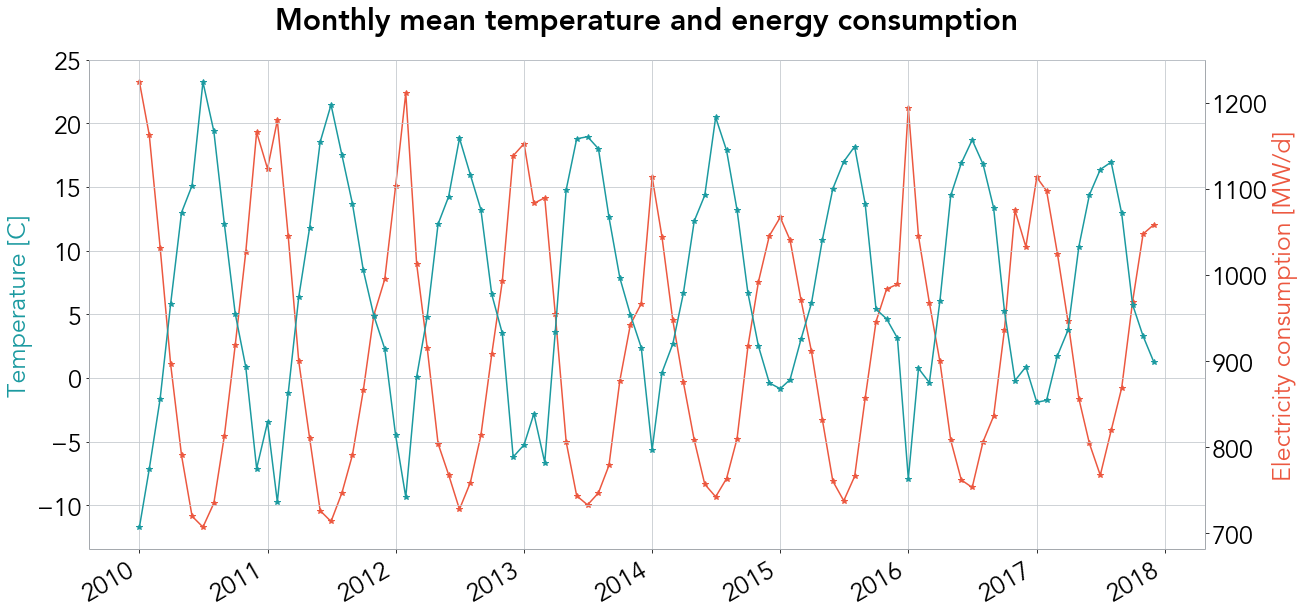

In [134]:
make_fig(monthly_mean_temp,monthly_mean_temp.time0-np.timedelta64(30,'D'),monthly_consumption.Tarbimine,\
         monthly_consumption.time-np.timedelta64(30,'D'),'Monthly mean temperature and energy consumption',\
         'monthly_hiiumaa_temperature_consumtion_uue_test.png','Temperature [C]','Electricity consumption [MW/d]')

In [95]:
shutil.rmtree(folder)

On Monthly Mean Temperature and Wind Speed figure we can see how usually warmer temperature means weaker wind. However, every winter at least some days temperature drops below -10 C while wind speed is also below 5 m/s. Knowing that, we will look into January and February each year a bit closer, to find out if we should be concerned. 

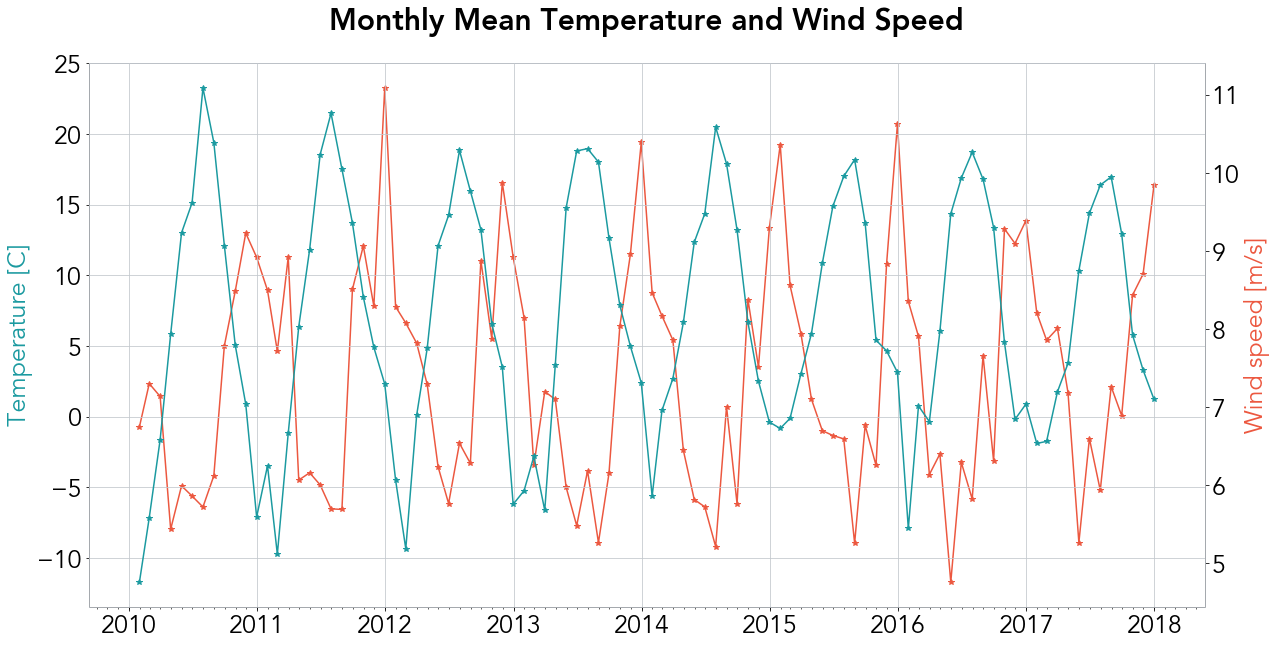

In [148]:
#make_fig(data1,time1,data2,time2,title,figname,y_label1,y_label2)
make_fig(monthly_mean_temp,monthly_mean_temp.time0,monthly_mean_wind,monthly_mean_wind.time0,'Monthly Mean Temperature and Wind Speed','monthly_hiiumaa_temperature_wind_uue_test.png','Temperature [C]','Wind speed [m/s]',savefig=False)

We are looking into January and February closer here. First we want to filter out Jan and Feb months (< 3) and then we can find daily means. ERA5 data is hourly, but we find that daily means are making more sense in this case. After calculating means we want to find out days where temperature was below -10 C and wind speed below 5 m/s. We add this data to pandas Dataframe and then print it out. 

In the table, we can see that this kind of situation (below -10 C and 5 m/s) was on 66 days over the period (2010-2017). It's not that bad for 8 year period, it mean in average there's only 8 days per year like this. 

In [130]:
data_jan_feb_wnd = dd1_wnd.sel(time0=dd1_wnd['time0.month']<3)
data_jan_feb_tmp = dd2_tmp.sel(time0=dd2_tmp['time0.month']<3)

jan_feb_daily_mean_wind = data_jan_feb_wnd.wind_speed.resample(time0="1D").mean('time0').mean(dim=('lat', 'lon'))
jan_feb_daily_mean_wind = jan_feb_daily_mean_wind.sel(time0=jan_feb_daily_mean_wind['time0.month']<3)

jan_feb_daily_mean_temp = data_jan_feb_tmp.temp_celsius.resample(time0="1D").mean('time0').mean(dim=('lat', 'lon'))
jan_feb_daily_mean_temp = jan_feb_daily_mean_temp.sel(time0=jan_feb_daily_mean_temp['time0.month']<3)

cold_weather_no_wind = pd.DataFrame()

for i,daily_temp in enumerate(jan_feb_daily_mean_temp):
    daily_wind = jan_feb_daily_mean_wind[i]
    index = 0
    if daily_temp < -10 and daily_wind < 5:
        cold_weather_no_wind = cold_weather_no_wind.append({"Date": daily_temp.time0.values,"Temp": daily_temp.values,"Wind":daily_wind.values}, ignore_index=True)

print (cold_weather_no_wind) 

         Date         Temp       Wind
0  2010-01-01    -13.21416  3.6306221
1  2010-01-02    -13.67566  3.6834543
2  2010-01-03  -11.3351145  3.8520043
3  2010-01-09   -11.248561  2.7856045
4  2010-01-10   -10.990357  3.1369197
5  2010-01-11    -15.84496  2.3664932
6  2010-01-19   -13.646876  4.9235873
7  2010-01-22   -17.431587   4.427509
8  2010-01-23   -21.633713   3.191883
9  2010-01-24   -22.422773   2.297692
10 2010-01-25    -13.73584  2.2148488
11 2010-01-26   -15.871854  3.0670345
12 2010-02-09   -10.313277  3.9883668
13 2010-02-10   -11.142353  1.5952463
14 2010-02-16   -11.435449  3.1525002
15 2010-02-17  -10.7053995  3.9485476
16 2010-02-18   -10.207169   3.795189
17 2011-02-13   -13.290093   4.656233
18 2011-02-14   -14.976093  3.8992453
19 2011-02-15    -18.06508  2.2365973
20 2011-02-16   -16.359266  3.4088335
21 2011-02-18   -21.911753  4.0405717
22 2011-02-19   -18.615286   2.622008
23 2011-02-20   -17.229311  2.1955192
24 2011-02-21   -15.501087  3.6671054
25 2011-02-2

In [149]:
print(jan_feb_daily_mean_temp.min())
print(jan_feb_daily_mean_temp.max())

<xarray.DataArray 'temp_celsius' ()>
array(-27.464609)
<xarray.DataArray 'temp_celsius' ()>
array(6.202113)


Below we like to make figure about each year January and February. Visualizations always makes it easier to understand the data. For example, we can see that 2017 winter had quite good wind conditions. There were only 3 days below 5 m/s from which only one day had temperature below -10 C, however, many days had cold temperature (below -10 C), but it remained windy. On the other hand, 2012 had cold period with very weak wind speed in the end of January and beginning of February. From here we can get pretty good vizual overview from coldest months of the year. 

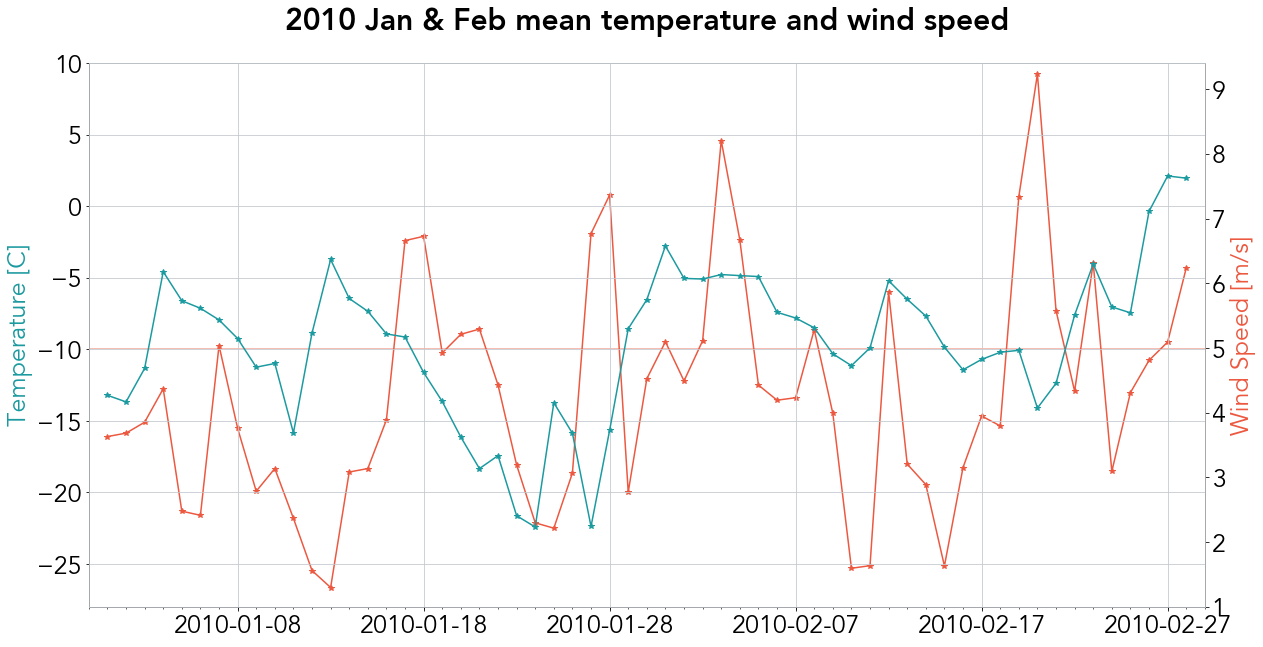

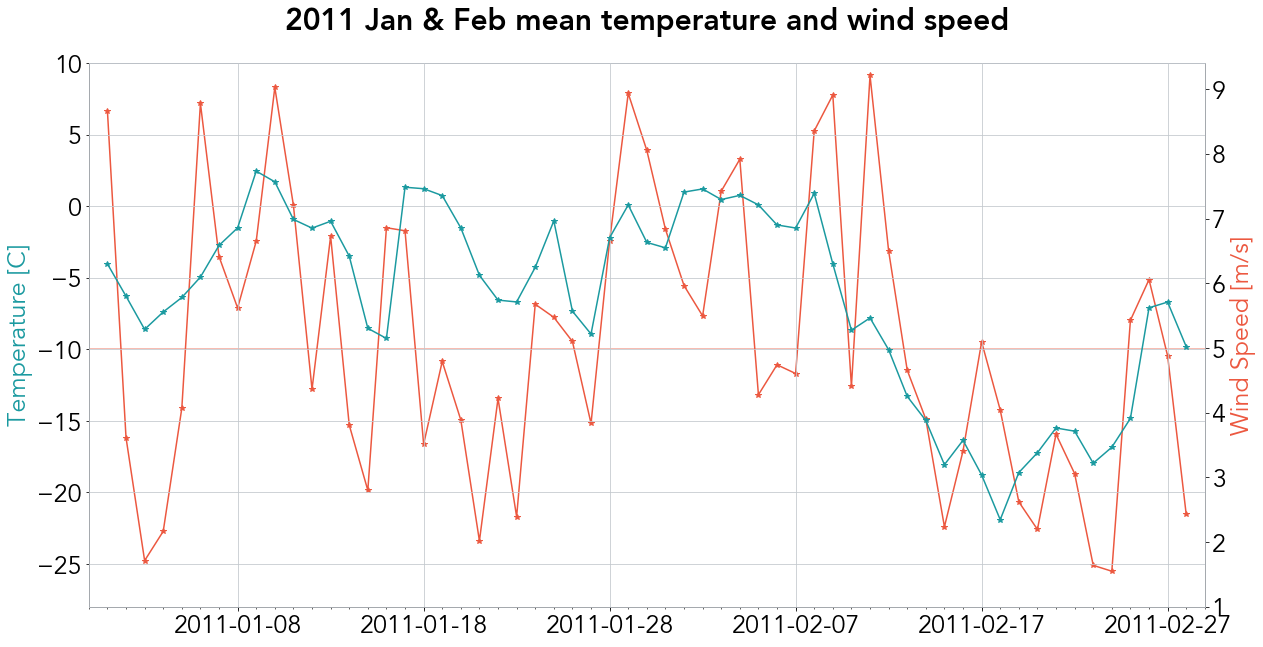

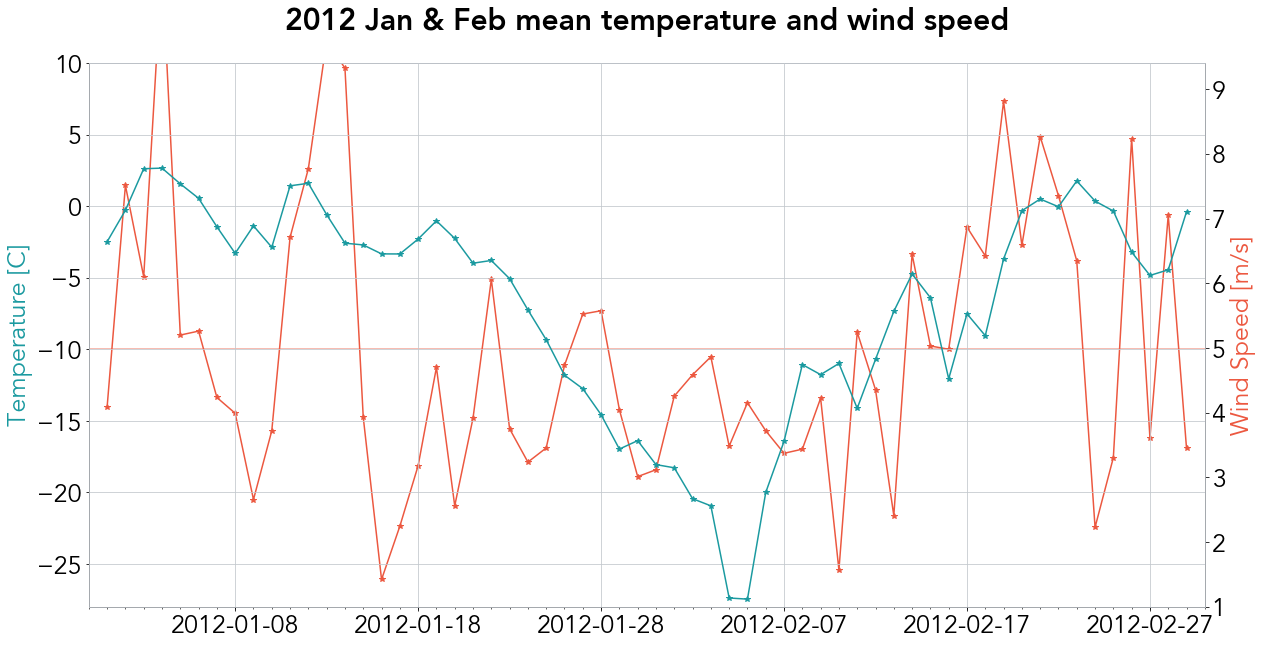

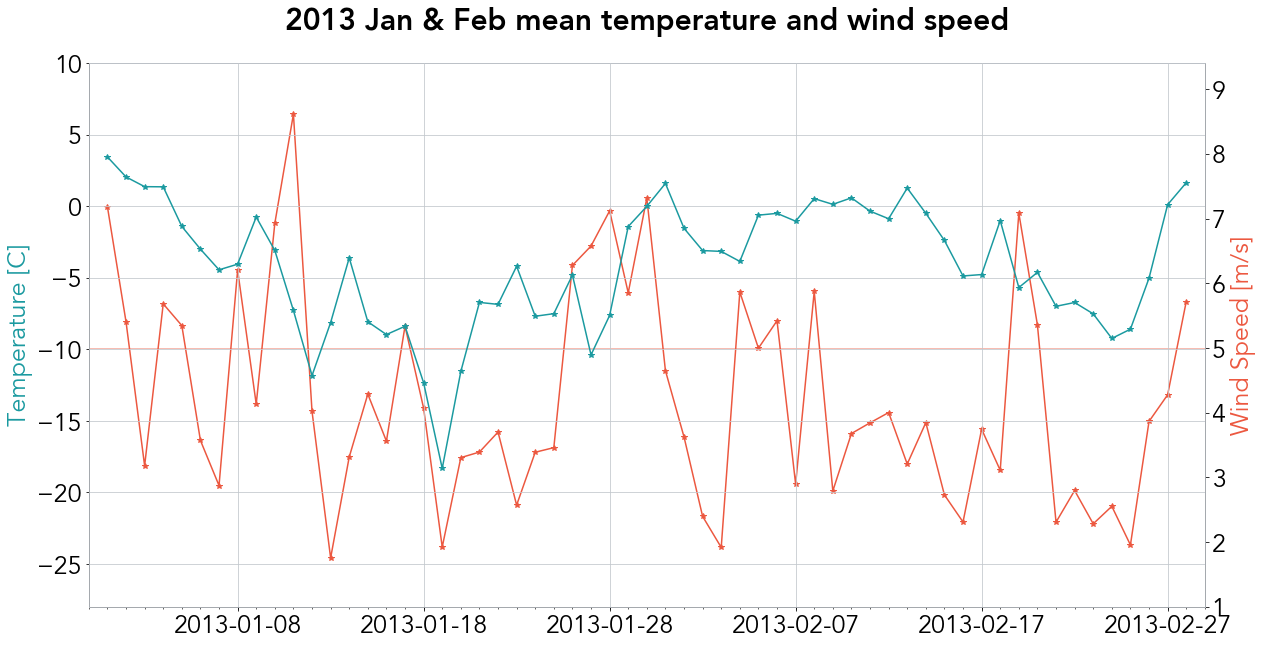

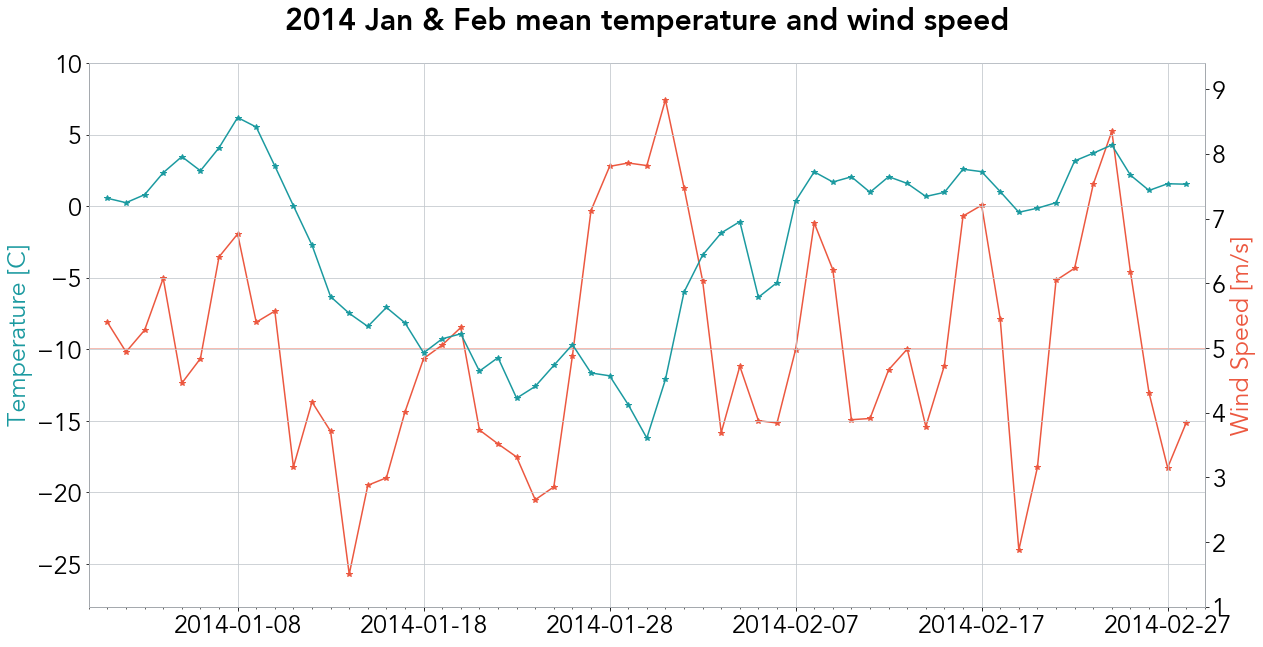

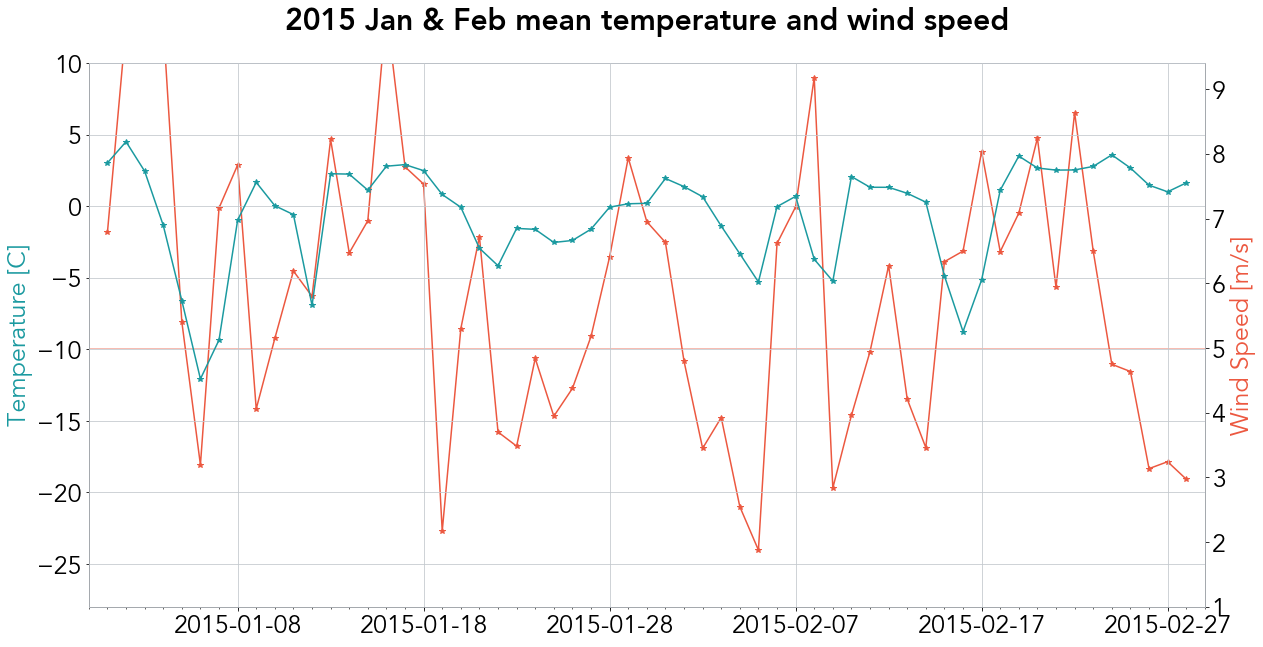

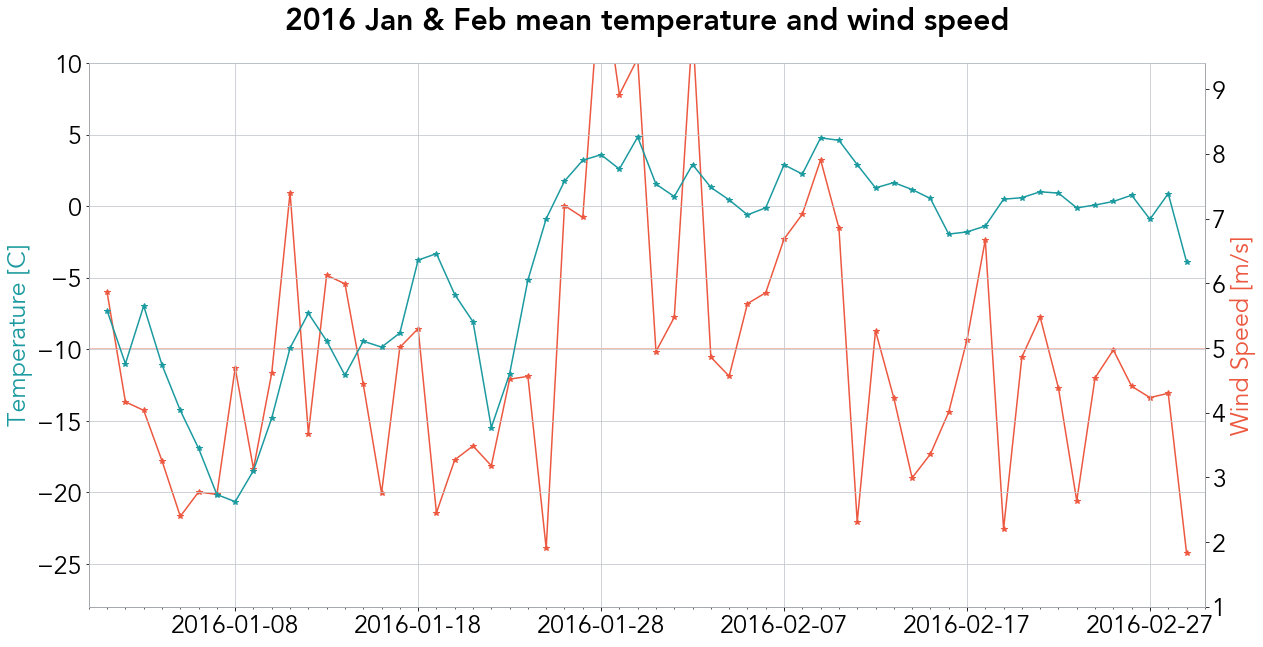

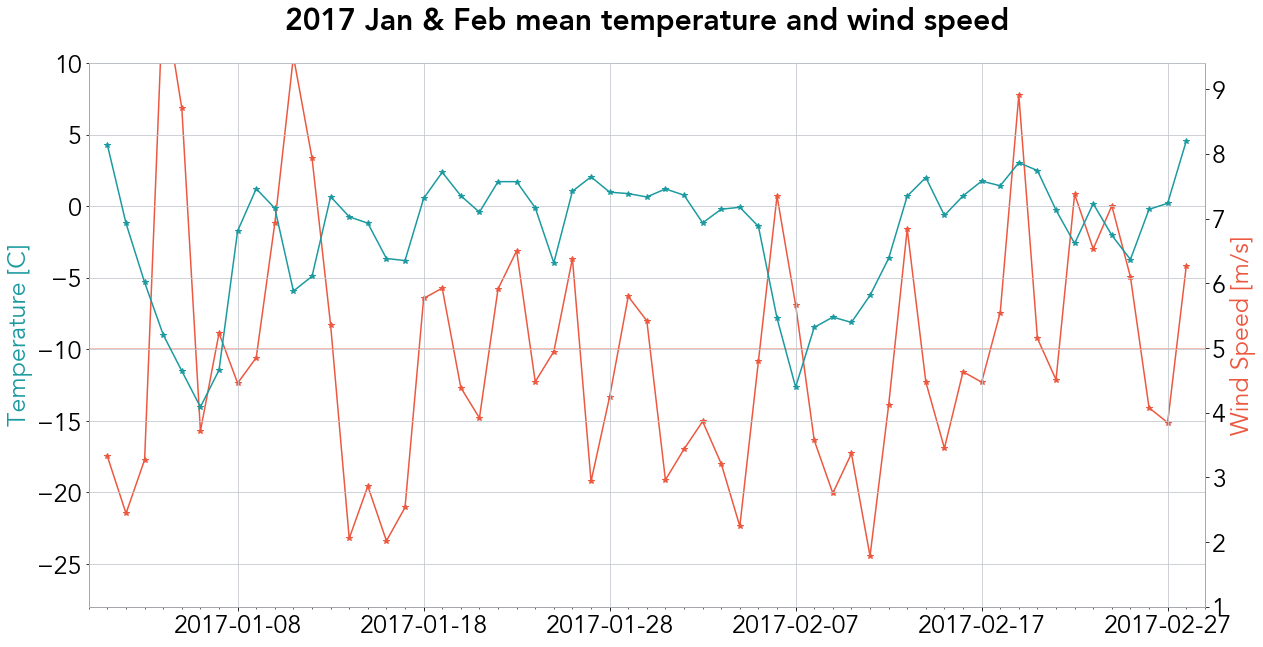

In [179]:
for year in np.arange(2010,2018,1):
    jan_feb_year_mean_wind = jan_feb_daily_mean_wind.sel(time0=jan_feb_daily_mean_wind['time0.year'] == year)
    jan_feb_year_mean_temp = jan_feb_daily_mean_temp.sel(time0=jan_feb_daily_mean_temp['time0.year'] == year)
    make_fig(jan_feb_year_mean_temp,jan_feb_year_mean_temp.time0,jan_feb_year_mean_wind,\
        jan_feb_year_mean_wind.time0, str(year) + ' Jan & Feb mean temperature and wind speed',\
         str(year) + '__temperature_wind.png','Temperature [C]','Wind Speed [m/s]',threshold=True,daily=True)
 

In conclusion, there were only 66 days during an 8 year period when wind speed was below 5 m/s. Of those 66 days, air temperature was relatively cold, around -10 or ever lower. So while there were days where high energy demand overcame low production, it really did not make any meaningful difference. Given what we believe the future to hold, more efficient turbines, grids and widespread battery storage, we foresee the days of fossil-fuel needing to compensate for subpar renewable performance grow fewer and farther between.